# EmoNet: Advanced Emotion Classification Using NLP Techniques
## Problem Statement:

Create an advanced emotion classification model leveraging state-of-the-art Natural Language Processing (NLP) techniques to accurately identify and categorize emotions expressed in textual data. The objective is to develop a model capable of effectively predicting the emotional sentiment associated with each document in a given dataset. This entails training the model on a diverse corpus of documents annotated with corresponding emotion labels and optimizing its performance to achieve high accuracy and robustness in classifying emotions across various contexts. The resulting model should exhibit superior capabilities in understanding and interpreting nuanced emotional nuances, enabling its application in a wide range of real-world scenarios such as sentiment analysis, customer feedback analysis, and mood detection in conversational interfaces.

## Aim:

- Develop a high-performing emotion classification model using NLP techniques to accurately categorize emotions expressed in textual data.

## Dataset Attributes

- Text Data: Each entry contains a piece of text representing a statement or expression of emotion. These textual documents vary in length and content, reflecting the diverse range of emotional experiences.

- Emotion Label: The emotion label indicates the predominant emotion conveyed in the corresponding text data. Emotions such as sorrow, rage, happiness, amaze, care, and scare are represented in the dataset.

### Import Libraries

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Load Dataset

In [2]:
path=os.getcwd()
df_train = pd.read_csv(path+'\\data\\train.csv')
df_test = pd.read_csv(path+'\\data\\test.csv')

# Questions
**Instructions:**
1.  Answer all questions.
2.  Justify your answers with appropriate reasoning, code, or calculations.
3.  Ensure your code is well-commented to explain your logic.
4.  Total Marks: 100

# Question 1 : Data Analysis (10 pt)

- Describe the dataset, including the number of entries (documents) present.
- Determine the frequency of each emotion category in the dataset.
- Utilize visualizations such as bar charts or pie charts to display the distribution of emotions in the dataset.
- Interpret the statistical plots to extract meaningful insights that can inform the development of the EmoNet model.

In [3]:
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sorrow
1,i can go from feeling so hopeless to so damned...,sorrow
2,im grabbing a minute to post i feel greedy wrong,rage
3,i am ever feeling nostalgic about the fireplac...,care
4,i am feeling grouchy,rage


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     15000 non-null  object
 1   Emotion  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


In [5]:
df_train.shape

(15000, 2)

In [6]:
df_train.isnull().any()

Text       False
Emotion    False
dtype: bool

In [7]:
duplicate_rows = df_train[df_train.duplicated()]
if len(duplicate_rows) > 0:
    print("Duplicate records found:")
    print(len(duplicate_rows))
else:
    print("No duplicate records found.")

Duplicate records found:
1


In [8]:
df_train.nunique()

Text       14973
Emotion        6
dtype: int64

In [9]:
emotion_counts=df_train['Emotion'].value_counts()
emotion_counts

Emotion
happiness    5034
sorrow       4368
rage         2016
scare        1817
care         1223
amaze         542
Name: count, dtype: int64

In [10]:
df_train.describe()

,Text,Emotion
count,15000,15000
unique,14973,6
top,i was intensely conscious of how much cash i h...,happiness
freq,2,5034


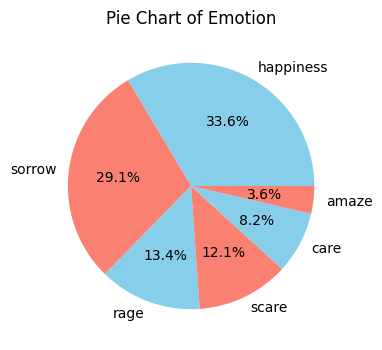

In [11]:
# Pie Chart for emotion
plt.figure(figsize=(4, 4))
emotion_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Pie Chart of Emotion')
plt.ylabel('')
plt.show()

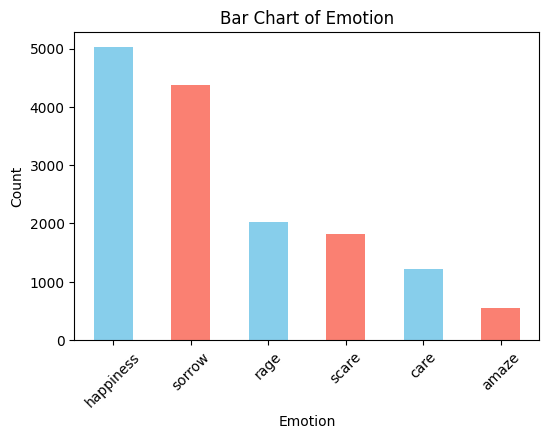

In [12]:
#bar chart for emotion
plt.figure(figsize=(6, 4))
emotion_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Bar Chart of Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<br>Observations</br>

1. The dataset contains 15000 entries with feature Text and the label Emotion.
2. Dataset consists of 6 classes in the target variable.
3. Looking at the statistical plots above, there is an imbalance in the classes.
4. The Bar chart of the target classes seems to be right skewed.

# Question 2: Data pre-processing & Feature Engineering (10 points)

- Preprocess the text data to remove noise and irrelevant information, such as punctuation, special characters, and stop words.
- Perform tokenization to break down the text data into individual words or tokens.
- Using the provided dataset, create a word cloud to visualize the frequency of words in the text. Describe the process you followed to create the word cloud.
- Experiment with different text representation techniques, such as frequency vector, TF-IDF (Term Frequency-Inverse Document Frequency)to transform the text data into numerical features that can be used by machine learning models.
### Extra credit if you perform word embeddings (e.g., Word2Vec, GloVe) to transform the text data into numerical features that can be used by machine learning models.

In [3]:
# Encoding Emotion
columns = ['Emotion']
label_encoders = {}
for col in columns:
    label_encoders[col] = LabelEncoder()
    df_train[col] = label_encoders[col].fit_transform(df_train[col])

In [4]:
for col, encoder in label_encoders.items():
    print(f"Column: {col}")
    for original_label, encoded_value in zip(encoder.classes_, encoder.transform(encoder.classes_)):
        print(f"Original Label: {original_label} -> Encoded Value: {encoded_value}")

Column: Emotion
Original Label: amaze -> Encoded Value: 0
Original Label: care -> Encoded Value: 1
Original Label: happiness -> Encoded Value: 2
Original Label: rage -> Encoded Value: 3
Original Label: scare -> Encoded Value: 4
Original Label: sorrow -> Encoded Value: 5


In [5]:
# Text Data Preprocessing
def preprocess_text(text):
    # Remove links, HTML tags, and unnecessary punctuation
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove emojis
    text = re.sub(r'[\uD800-\uDBFF][\uDC00-\uDFFF]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

In [6]:
df_train['Text'] = df_train['Text'].apply(preprocess_text)
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,5
1,i can go from feeling so hopeless to so damned...,5
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,3


In [7]:
#removing stopwords
stop_words = set(stopwords.words('english'))
df_train['Text'] = df_train['Text'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))

In [156]:
#tokenization
df_train['tokens'] = df_train['Text'].apply(nltk.word_tokenize)
df_train['tokens']

0                                [didnt, feel, humiliated]
1        [go, feeling, hopeless, damned, hopeful, aroun...
2        [im, grabbing, minute, post, feel, greedy, wrong]
3        [ever, feeling, nostalgic, fireplace, know, st...
4                                       [feeling, grouchy]
                               ...                        
14995             [feel, sympathetic, empathetic, towards]
14996    [brief, time, beanbag, said, anna, feel, like,...
14997                        [feel, strong, good, overall]
14998                [feel, like, rude, comment, im, glad]
14999                   [know, lot, feel, stupid, portray]
Name: tokens, Length: 15000, dtype: object

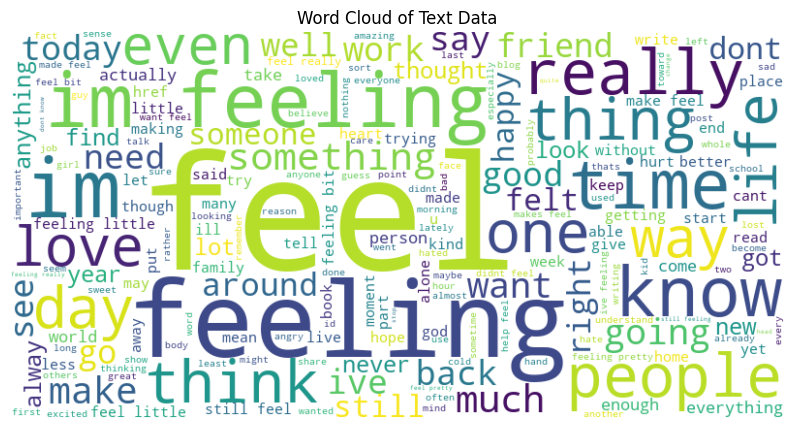

In [19]:
#Generating Word cloud
text_combined = ' '.join(df_train['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

<br>Observations</br>
1. Creating a single string of text combining text from Text feature of dataframe. 
1. Using the WordCloud module, generating word cloud to visualize the top frequent words of the text string created.
2. Some of the words with highest frequency obtained from the word cloud above are - feel, feeling, Im feeling etc.
3. The top words obtained seems like different forms of same root word - feel

In [9]:
#Frequency vectorization
count_vectorizer = CountVectorizer()
X_freq = count_vectorizer.fit_transform(df_train['Text'])

In [10]:
#TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_train['Text'])

In [11]:
#Word2Vec embeddings
#Tokenize text column
sentences = [simple_preprocess(text) for text in df_train['Text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)    
    return feature_vector

# Create Word2Vec features
X_word2vec = [average_word_vectors(sent, w2v_model, w2v_model.wv.index_to_key, 100) for sent in sentences]
X_word2vec = np.array(X_word2vec)

In [ ]:
pca = PCA(n_components=2)
X_pca_freq = pca.fit_transform(X_freq.toarray())

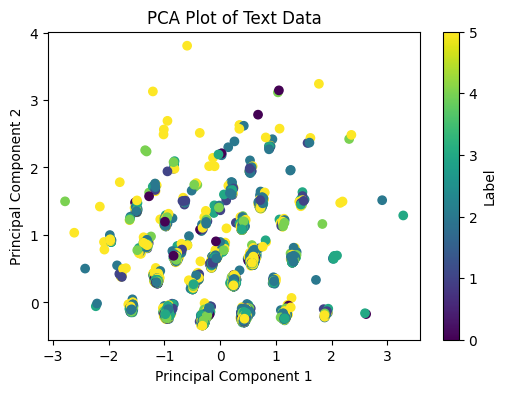

In [17]:
# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(X_pca_freq[:, 0], X_pca_freq[:, 1], c=df_train['Emotion'], cmap='viridis')
plt.title('PCA Plot of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Label')
plt.show()

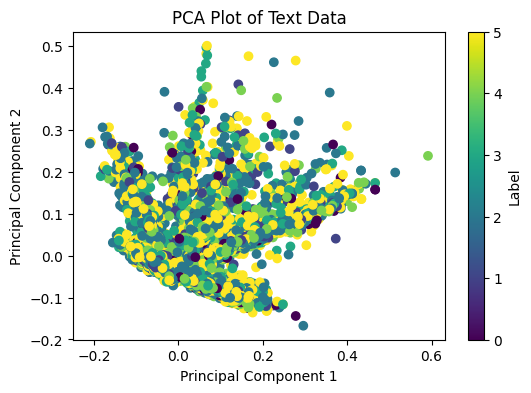

In [18]:
pca = PCA(n_components=2)
X_pca_tfidf = pca.fit_transform(X_tfidf.toarray())

# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(X_pca_tfidf[:, 0], X_pca_tfidf[:, 1], c=df_train['Emotion'], cmap='viridis')
plt.title('PCA Plot of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Label')
plt.show()

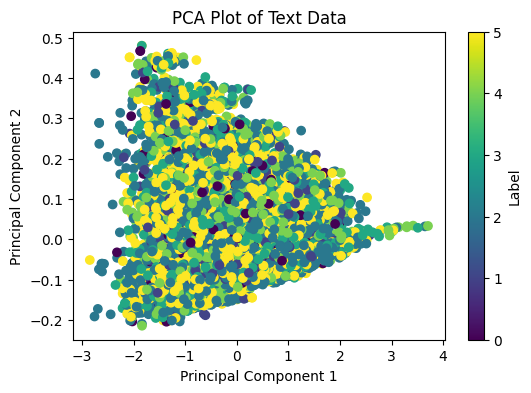

In [20]:
pca = PCA(n_components=2)
X_pca_word2vec = pca.fit_transform(X_word2vec)

# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(X_pca_word2vec[:, 0], X_pca_word2vec[:, 1], c=df_train['Emotion'], cmap='viridis')
plt.title('PCA Plot of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Label')
plt.show()

<br>Observations : </br>
1. Converted the text/words column to numeric representations using Frequency vectorization, TFIDF vectorization and Word2Vec as well.
2. As we progress through the models, the dimensionality of the vector representations improved indicating more details are being captured in the latter methods used.

# Question 3 - LDA(10 points)

- Apply Latent Dirichlet Allocation (LDA) to uncover themes in the text data. Set the number of topics to 8 and extract 10 keywords per topic. 
- Describe your approach, including any preprocessing steps. Present the identified topics with their keywords. 
- Discuss the importance of topic modeling in revealing hidden themes and extracting insights from the dataset.

In [45]:
# LDA
lda_model_freq = LatentDirichletAllocation(n_components=8, random_state=42)
lda_model_tfidf = LatentDirichletAllocation(n_components=8, random_state=42)
lda_model_word2vec = LatentDirichletAllocation(n_components=8, random_state=42)

lda_freq = lda_model_freq.fit_transform(X_freq)
lda_tfidf = lda_model_tfidf.fit_transform(X_tfidf)

In [46]:
X_word2vec_non_negative = X_word2vec + np.abs(np.min(X_word2vec))
lda_word2vec = lda_model_word2vec.fit_transform(X_word2vec_non_negative)

In [47]:
def get_lda_keywords(lda_model, feature_names, n_top_words):
    lda_keywords = []
    for topic_idx, topic in enumerate(lda_model.components_):
        # Get the indices of top words based on their frequency of occurrence
        top_keywords_idx = np.argsort(topic)[::-1][:n_top_words]
        keywords = [feature_names[i] for i in top_keywords_idx]
        lda_keywords.append(keywords)
    return lda_keywords

# Extracting keywords for each LDA model
n_top_words = 10
lda_freq_keywords = get_lda_keywords(lda_model_freq, count_vectorizer.get_feature_names_out(), n_top_words)
lda_tfidf_keywords = get_lda_keywords(lda_model_tfidf, tfidf_vectorizer.get_feature_names_out(), n_top_words)
lda_word2vec_keywords = get_lda_keywords(lda_model_word2vec, w2v_model.wv.index_to_key, n_top_words)

In [48]:
def print_lda_keywords(lda_keywords):
    for i, keywords in enumerate(lda_keywords):
        print(f"Topic {i}: {' | '.join(keywords)}")

# Printing LDA keywords for each model
print("LDA keywords for Frequency-based LDA model:")
print_lda_keywords(lda_freq_keywords)
print("\nLDA keywords for TF-IDF-based LDA model:")
print_lda_keywords(lda_tfidf_keywords)
print("\nLDA keywords for Word2Vec-based LDA model:")
print_lda_keywords(lda_word2vec_keywords)

LDA keywords for Frequency-based LDA model:
Topic 0: feel | feeling | im | like | really | pretty | time | right | little | good
Topic 1: feeling | feel | im | like | know | morning | feels | dont | night | woke
Topic 2: feel | like | feeling | get | im | people | want | would | really | help
Topic 3: feel | feeling | im | like | need | know | still | time | people | life
Topic 4: feel | like | feeling | life | way | time | ive | friends | people | one
Topic 5: feel | like | feeling | know | want | always | didnt | get | make | things
Topic 6: feel | like | little | feeling | feelings | know | bit | still | love | im
Topic 7: feel | feeling | im | like | days | go | work | really | much | one

LDA keywords for TF-IDF-based LDA model:
Topic 0: feel | feeling | im | like | overwhelmed | really | pretty | little | time | good
Topic 1: feel | feeling | im | like | disheartened | gloomy | miserable | know | low | mellow
Topic 2: feel | feeling | like | im | really | want | people | help | a

# Question 4 - Modeling (20 points)

- Train at least three different  models.
- Choose the best feature engineering method and perform grid search & cross-validation to tune hyperparameters for three different models, optimizing their performance for emotion classification and Also, for each model, plot the ROC-AUC curve?

In [86]:
X_tfidf.shape

(15000, 14564)

In [83]:
y=df_train['Emotion']

In [87]:
y.shape

(15000,)

In [84]:
#splitting train and val
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [103]:
#using word2vec data
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

- Grid Search

In [97]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

In [98]:
pipeline = Pipeline([
    ('clf', None)
])

In [99]:
params_grid = {
    'Logistic Regression': {
        'clf': [LogisticRegression()],
        'clf__C': [0.001, 0.1, 1, 10],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 50]
    },
    'Decision Tree': {
        'clf': [DecisionTreeClassifier()],
        'clf__max_depth': [None, 10, 20, 50]
    }
}

In [100]:
best_models_freq = {}

In [101]:
#Gridsearch for tfidf vectorized data
for name, model in models.items():
    grid_search = GridSearchCV(pipeline, params_grid[name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models_freq[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for Logistic Regression: {'clf': LogisticRegression(), 'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Random Forest: {'clf': RandomForestClassifier(), 'clf__max_depth': None, 'clf__n_estimators': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Decision Tree: {'clf': DecisionTreeClassifier(), 'clf__max_depth': None}


In [110]:
print(best_models_freq)

{'Logistic Regression': Pipeline(steps=[('clf', LogisticRegression(C=10, penalty='l1', solver='saga'))]), 'Random Forest': Pipeline(steps=[('clf', RandomForestClassifier())]), 'Decision Tree': Pipeline(steps=[('clf', DecisionTreeClassifier())])}


In [104]:
best_models_word2vec={}

In [ ]:
#Gridsearch for Word2Vec embedded data
for name, model in models.items():
    grid_search = GridSearchCV(pipeline, params_grid[name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train2, y_train2)
    best_models_word2vec[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

In [106]:
def compute_balanced_accuracy(y_true, y_pred):
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    return balanced_acc

In [111]:
def compute_roc_auc(y_true, y_pred_proba):
    n_classes = y_pred_proba.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return fpr, tpr, roc_auc

- ROC Curves

Model: Logistic Regression
ROC-AUC Score: {0: 0.9911966104356409, 1: 0.9816011723361405, 2: 0.9870046989885587, 3: 0.9928361776809489, 4: 0.9877711357994409, 5: 0.9884605144043879}
Balanced Accuracy: 0.8546150678234188



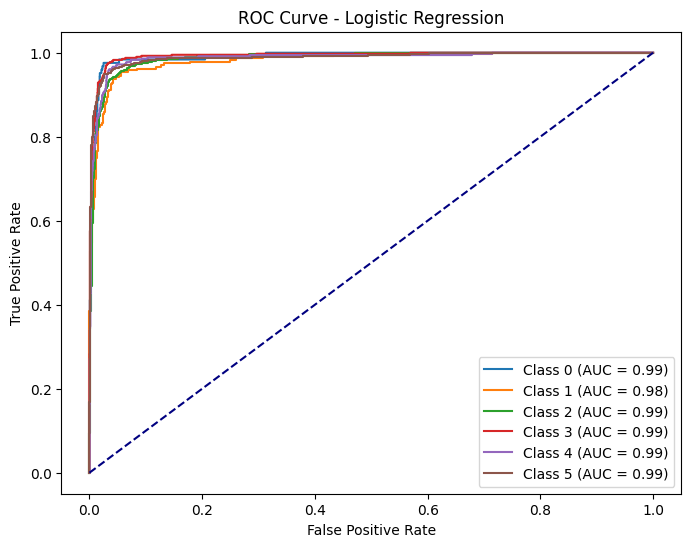

Model: Random Forest
ROC-AUC Score: {0: 0.9951054892547894, 1: 0.9890949704415507, 2: 0.982298894447701, 3: 0.9930460996126846, 4: 0.9928872447231867, 5: 0.987472708876937}
Balanced Accuracy: 0.8383995539252848



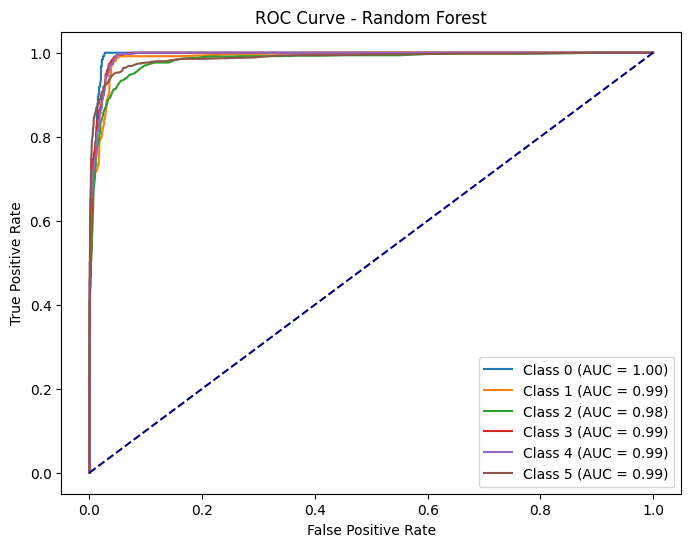

Model: Decision Tree
ROC-AUC Score: {0: 0.8664475750370138, 1: 0.8741655667175346, 2: 0.9208480192503531, 3: 0.9316675744371822, 4: 0.9066931265039604, 5: 0.9372836679269397}
Balanced Accuracy: 0.8391725950137413



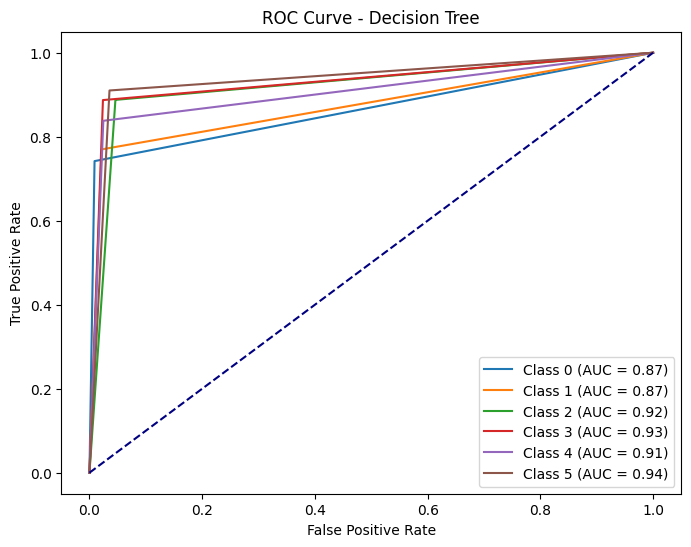

In [142]:
def evaluate_models(X_test, y_test, best_models):
    roc_auc_scores = {}
    balanced_accuracy_scores = {}

    for name, model in best_models.items():
        y_pred_proba = model.predict_proba(X_test)
        fpr, tpr, roc_auc = compute_roc_auc(y_test, y_pred_proba)
        roc_auc_scores[name] = roc_auc
        y_pred = model.predict(X_test)
        balanced_accuracy_scores[name] = compute_balanced_accuracy(y_test, y_pred)

        print(f"Model: {name}")
        print(f"ROC-AUC Score: {roc_auc}")
        print(f"Balanced Accuracy: {balanced_accuracy_scores[name]}")
        print()

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        for i in range(len(fpr)):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc_scores, balanced_accuracy_scores

roc_auc_scores_tfidf, balanced_accuracy_scores_tfidf = evaluate_models(X_val, y_val, best_models_freq)

# Question 5 - Evaluation and Reporting (20 points)

- Select a model that is expected to perform optimally on the unseen data and provide the predictions accordingly. Give clear conclusions


Based on roc_auc scores and balanced accuracy scores obtained for all the models trained and optimized through grid search, Logistic Regression seems to perform compared to other models. So, taking Logistic Regression with best parameters as our final model

In [143]:
#splitting train and val, to evaluate the model
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [145]:
final_model = LogisticRegression(C=10, penalty='l1', solver='saga')

In [154]:
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on Validation Data: {accuracy}")
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
print(f"Balanced Accuracy on Validation Data: {balanced_accuracy}")

Accuracy on Validation Data: 0.9033333333333333
Balanced Accuracy on Validation Data: 0.8534239053711349


C:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Question 6 : External validation (30 pt)

- A dataset named ‘test.csv’ is provided to you in which the label is hidden. You have to choose the best model(the model which has the highest score) and then use that model to predict the label on the ‘test.csv’.
- You need to generate a csv file, named as "submission.csv". This is the inference values from your selected best model on "test.csv" data.

In [171]:
def pre_process_test(df):
    df['Text'] = df['Text'].apply(preprocess_text)
    df['Text'] = df['Text'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))
    X_tfidf_test = tfidf_vectorizer.transform(df['Text'])
    y_pred_test=final_model.predict(X_tfidf_test)
    y_pred_test=label_encoders['Emotion'].inverse_transform(y_pred_test)
    return y_pred_test

In [172]:
test = pd.read_csv('./data/test.csv')
pred = pre_process_test(test)
pred = pd.DataFrame(pred)
pred.to_csv('./submission.csv', index = False)
print('file saved')

file saved


# Hint - Final evaluation metrics
Please use the below function named 'model_evaluation' in order to calculate the evaluation metrics.

In [ ]:
from sklearn.metrics import balanced_accuracy_score

def evaluation_metrics(y_test, y_pred):
    # Calculate the balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Return the balanced accuracy as a single digit number
    print('The Balanced accuracy is : ', balanced_accuracy)